In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import networkx as nx
import constants
import copy

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')

In [2]:
nodes = gpd.read_file("data/ego/nodes.shp")
edges = gpd.read_file("data/ego/edges.shp")

# set indexes for the GeoDataFrame (just for to be sure)
nodes = nodes.set_index("osmid")
edges = edges.set_index(['u', 'v', 'key'])

Since we want to mark the points determined by the centrality, we need to create a new column in the DataFrame, one for each category.

In [3]:
for category in constants.CATEGORIES:
    nodes[f"c_{category}"] = False

nodes["cen"] = False
# convert to osmnx graph    
G = ox.utils_graph.graph_from_gdfs(nodes, edges)

We want to analyze results using two different centralities (i.e. Betweenness and Closeness), so create two deep copies of the graph

In [4]:
# keep copies of the original graph for betweeneess centrality and closeness centrality updates
G_bc = copy.deepcopy(G)
G_cc = copy.deepcopy(G)

category: edu	 covered nodes: 3218
number of nodes before removing covered nodes: 5462
number of nodes after removing covered nodes: 2244
number of ndoes after removing small components: 1872
number of communities: 48


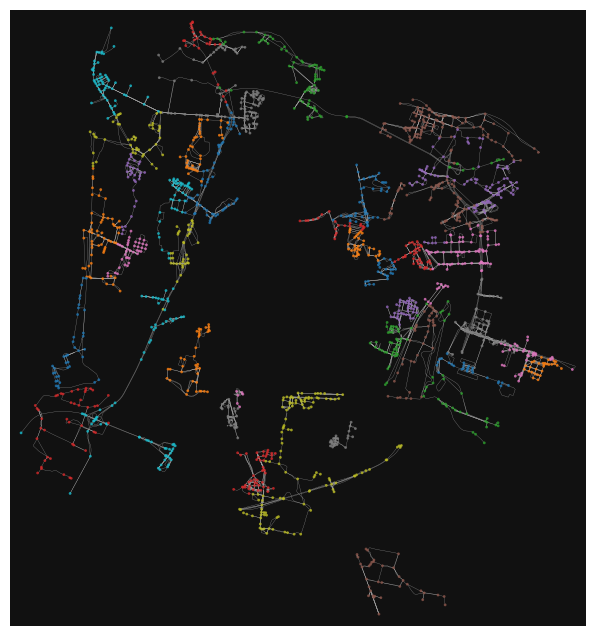

category: health	 covered nodes: 2565
number of nodes before removing covered nodes: 5462
number of nodes after removing covered nodes: 2897
number of ndoes after removing small components: 2724
number of communities: 54


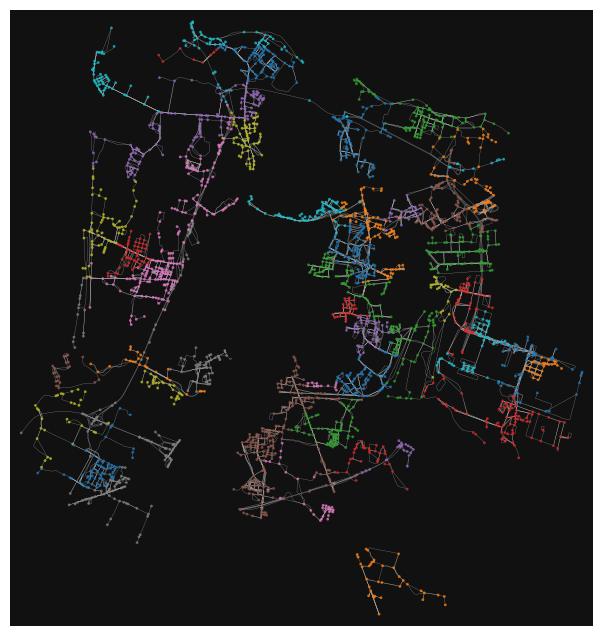

category: transp	 covered nodes: 4745
number of nodes before removing covered nodes: 5462
number of nodes after removing covered nodes: 717
number of ndoes after removing small components: 486
number of communities: 30


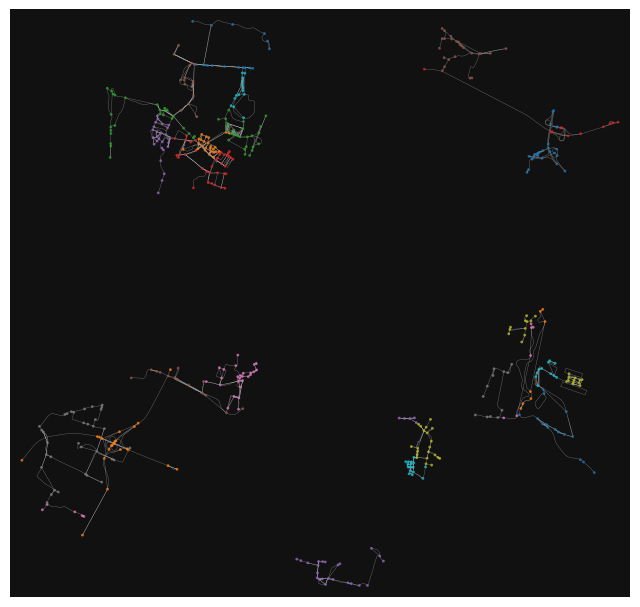

category: food	 covered nodes: 3669
number of nodes before removing covered nodes: 5462
number of nodes after removing covered nodes: 1793
number of ndoes after removing small components: 1519
number of communities: 47


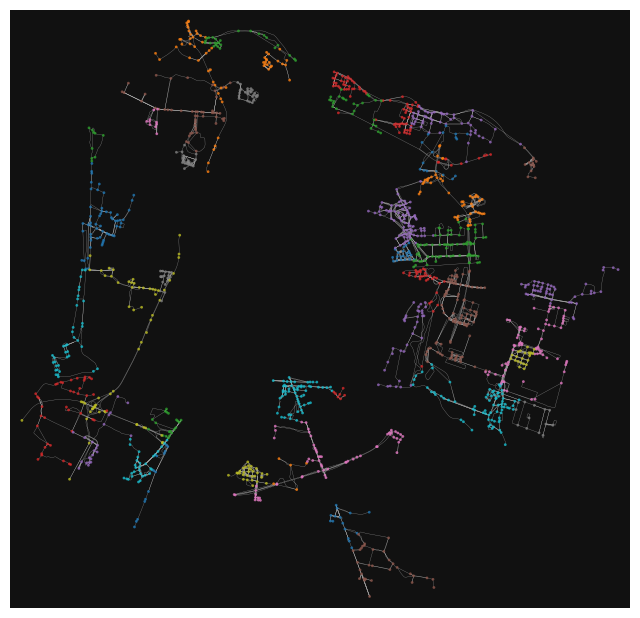

total number of communities: 179


In [5]:
total_communities = 0
for category in constants.CATEGORIES:
    G_copy = copy.deepcopy(G)

    # remove already covered nodes
    covered_nodes = []
    for node, data in G.nodes(data=True):
        covered = data.get(category, False)
        if covered:
            covered_nodes.append(node)
        
    print(f"category: {category}\t covered nodes: {len(covered_nodes)}")

    print(f"number of nodes before removing covered nodes: {len(G_copy.nodes())}")
    G_copy.remove_nodes_from(covered_nodes)
    print(f"number of nodes after removing covered nodes: {len(G_copy.nodes())}")

    # remove connected components with less than 20 nodes (small optimization, not worth it to cover small isolated communities)
    rmv_list = []
    for c in sorted(nx.connected_components(ox.utils_graph.get_undirected(G_copy)), key=len, reverse=True):
        if len(c) <= 20:
            rmv_list.extend(list(c))
    G_copy.remove_nodes_from(rmv_list)
    print(f"number of ndoes after removing small components: {len(G_copy.nodes())}")

    # use louvain algorithm for finding communities
    communities = nx.community.louvain_communities(G_copy, weight="time") # list of sets (communities)
    print(f"number of communities: {len(communities)}")
    total_communities += len(communities)

    # color mapping for plotting
    color_map = {}
    for i, community in enumerate(communities):
        # set node attribute on the graph
        # the attribute is "community": number
        node_dict = {node_id: {"community": i} for node_id in community}
        nx.set_node_attributes(G_copy, node_dict)
    
        # color map for plotting
        color = f'C{i}'
        for node in community:
            color_map[node] = color

    # plot the graph
    fig, ax = ox.plot_graph(
        G_copy,
        node_color=[color_map[node] for node in G_copy.nodes()],
        node_size=4,
        node_alpha=0.8,
        edge_linewidth=0.2,
        edge_color="#999999",
    )

    for community in communities:
        sub = nx.subgraph(G_copy,community)
    
        bc = nx.betweenness_centrality(sub, weight="time")
        cc = nx.closeness_centrality(sub, distance="time")
        max_key_bc = max(bc, key=bc.get)
        max_key_cc = max(cc, key=cc.get)

        G_bc.nodes[max_key_bc]["cen"] = True
        G_bc.nodes[max_key_bc][f"c_{category}"] = True

        G_cc.nodes[max_key_cc]["cen"] = True
        G_cc.nodes[max_key_cc][f"c_{category}"] = True
print(f"total number of communities: {total_communities}")

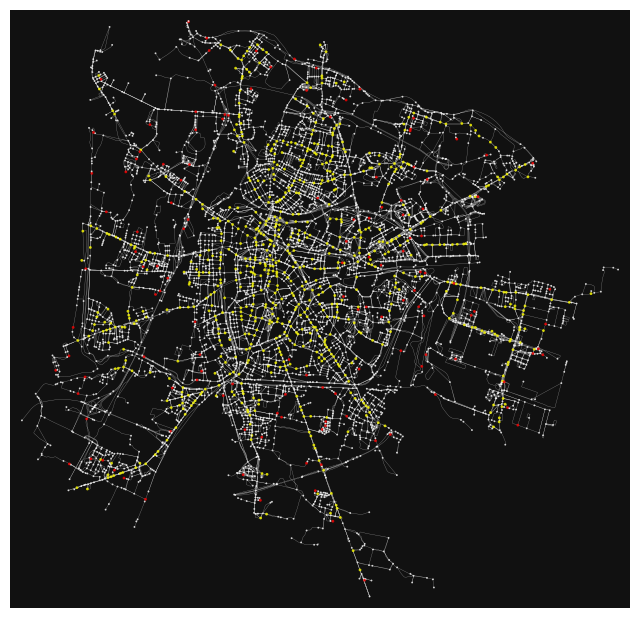

In [6]:
## color the nodes: white - normal; yellow - POIs; red - new POIs
# here's the code for the Closeness centrality
node_colors = {}
node_sizes = {}
s=0
for node, data in G_cc.nodes(data=True):
    poi = data.get("POI", None)
    poi_cc = data.get("cen", False)
    if poi in constants.CATEGORIES:
        node_colors[node] = "yellow"
        node_sizes[node] = 4
    elif poi_cc:
        node_colors[node] = "red"
        node_sizes[node] = 4
    else:
        node_colors[node] = "white"
        node_sizes[node] = 1.8

    for c in constants.CATEGORIES:
        cc = data.get(f"c_{c}", False)
        if cc:
            s+=1
        

assert s == total_communities

nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [node_sizes[node] if node in node_sizes else "none" for node in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

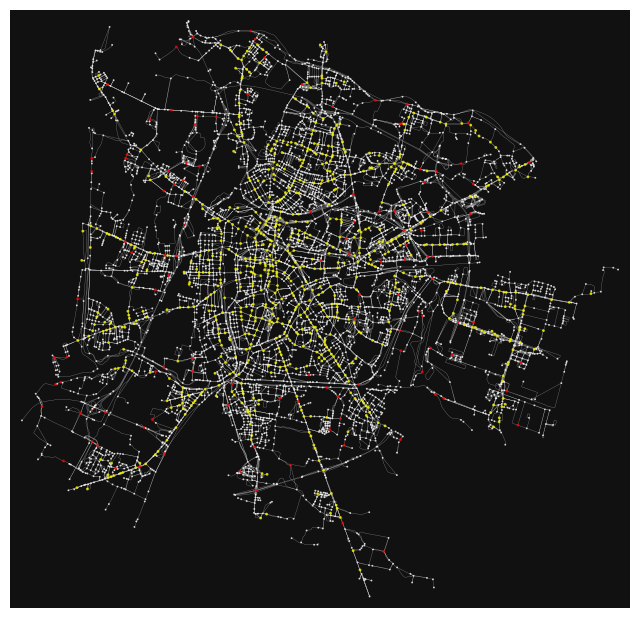

In [7]:
## color the nodes: white - normal; yellow - POIs; red - new POIs
# here's the code for the Betweenness centrality
node_colors = {}
node_sizes = {}
s = 0
for node, data in G_bc.nodes(data=True):
    poi = data.get("POI", None)
    poi_bc = data.get("cen", False)
    if poi in constants.CATEGORIES:
        node_colors[node] = "yellow"
        node_sizes[node] = 4
    elif poi_bc:
        node_colors[node] = "red"
        node_sizes[node] = 4
    else:
        node_colors[node] = "white"
        node_sizes[node] = 1.8

    for c in constants.CATEGORIES:
        bc = data.get(f"c_{c}", False)
        if bc:
            s+=1

assert s == total_communities

nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [node_sizes[node] if node in node_sizes else "none" for node in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [8]:
nodes = ox.graph_to_gdfs(G_bc, edges=False)
#nodes[nodes["bc_food"]==True]
nodes.head()

,osmid_orig,x,y,street_cou,POI,edu,health,transp,food,c_edu,c_health,c_transp,c_food,cen,lon,lat,highway,ref,geometry
osmid,,,,,,,,,,,,,,,,,,,
0,"[141540485, 254672751, 197522982, 254672878, 2...",724701.900173,5.034203e+06,0,transp,1,1,1,1,False,False,False,False,False,NaN,NaN,NaN,NaN,POINT (724701.900 5034203.206)
235,"[197523004, 345286935, 1706766370, 559475298, ...",724667.547169,5.034311e+06,0,NaN,1,1,1,1,False,False,False,False,False,NaN,NaN,NaN,NaN,POINT (724667.547 5034311.202)
233,243488899,724825.279648,5.034265e+06,5,NaN,1,1,1,1,False,False,False,False,False,11.873938,45.425744,NaN,NaN,POINT (724825.280 5034265.244)
628,"[2522360857, 243486447, 2522360875, 2522360879...",724832.620828,5.033955e+06,0,transp,1,1,1,1,False,False,False,False,False,NaN,NaN,NaN,NaN,POINT (724832.621 5033954.570)
643,243487238,724773.189779,5.034232e+06,3,NaN,1,1,1,1,False,False,False,False,False,11.873258,45.425462,NaN,NaN,POINT (724773.190 5034231.991)


In [9]:
ox.save_graph_shapefile(G_bc, filepath="data/communities_bc", encoding="utf-8")
ox.save_graph_shapefile(G_cc, filepath="data/communities_cc", encoding="utf-8")